# МФТИ: МТИИ 2020 Python. 
## Семинар 6: json/yaml, Redis, GIL, Ray, Pygraphviz.

## Разминка ([выражения генераторы](https://www.python.org/dev/peps/pep-0289/#the-details)) 


In [ ]:
# генератор
a = [index for index in range(10)]
print(a)

In [ ]:
# выражение генератор (generator expression)
a = (index for index in range(10))
print(a)
for value in a:
    print(value, end=', ')

Что будет напечатано в результате?

In [ ]:
a = [1, 2, 3]
b = [10, 20, 30]
gen = (x + y for x in a for y in b)
print(type(gen))
a = [4, 5, 6]
b = [400, 500, 600]
print(list(gen))

## Использование json и yaml для сериализации
Пусть у нас есть следующий словарь, который мы хотим сохранить:

In [ ]:
data = {
    "first_name": "Jane",
    "last_name": "Doe",
    "hobbies": ["running", "sky diving", "singing"],
    "age": 35,
    "children": [
        {
            "first_name": "Alice",
            "age": 6
        },
        {
            "first_name": "Bob",
            "age": 8
        }
    ]
}

Импортируем библиотеку json и используем метод dump:

In [ ]:
import json

with open("data.json", "w") as f:
    json.dump(data, f)

Посмотрим на содержимое файла:

In [14]:
!cat data.json

{"first_name": "Jane", "last_name": "Doe", "hobbies": ["running", "sky diving", "singing"], "age": 35, "children": [{"first_name": "Alice", "age": 6}, {"first_name": "Bob", "age": 8}]}

Теперь прочитаем словарь и сохраним его в new_data и напечатаем ```first_name```:

In [15]:
with open("data.json", "r") as f:
    new_data = json.load(f)
    print(new_data['first_name'])

Jane


## PyYaml
Yaml $-$ это удобочитаемый язык сериализации данных. Обычно, для файлов используется формат ```.yaml```. Посмотрим пример, для удобства у нас будет использован не внешний файл, а строка:

In [16]:
import yaml
document = """
a: 1
b:
    c: 3
    d: 4
e: [1, 2, 3]
f:
    - 1
    - 2
    - 3

g: True
h: hello #hello
# z: 5 <- comment

"""
q = yaml.load(document, Loader=yaml.FullLoader)
print(q)

{'a': 1, 'b': {'c': 3, 'd': 4}, 'e': [1, 2, 3], 'f': [1, 2, 3], 'g': True, 'h': 'hello'}


Если мы работаем с файлами, у нас точно также работают методы ```dump``` и ```load```:

In [17]:
with open('data.yaml', 'w') as f:
    data = yaml.dump(q, f)

In [18]:
!cat data.yaml

a: 1
b:
  c: 3
  d: 4
e:
- 1
- 2
- 3
f:
- 1
- 2
- 3
g: true
h: hello


In [19]:
with open("data.yaml", "r") as f:
    new_doc = yaml.load(f, Loader=yaml.FullLoader)
    print(new_doc)

{'a': 1, 'b': {'c': 3, 'd': 4}, 'e': [1, 2, 3], 'f': [1, 2, 3], 'g': True, 'h': 'hello'}


## Key-value базы данных: Redis

Установка:
```bash
sudo apt-get install redis-server
pip3 install redis
```

In [22]:
import redis

r = redis.Redis(host='localhost', port=6379, db=13)                                                        

In [23]:
print(r.get('foo'))

None


In [24]:
r.set('foo', 'bar')                                                     

True

In [25]:
r.get('foo')   

b'bar'

Подробнее: https://pypi.org/project/redis/

## GIL (Global Interpeter Lock) в Python

Начнем сразу с примера программы:

In [26]:
def count(n):
    while n > 0:
        n -= 1
        
x = 100000000

Запустим два раза и измерим время:

In [29]:
%%time
count(x)
count(x)

CPU times: user 5.59 s, sys: 0 ns, total: 5.59 s
Wall time: 5.59 s


Также запустим две функции, но теперь они будут выполняться параллельно:

In [30]:
from threading import Thread

In [31]:
%%time
t1 = Thread(target=count,args=(x,))
t1.start()
t2 = Thread(target=count,args=(x,))
t2.start()
t1.join()
t2.join()

CPU times: user 8.59 s, sys: 15.7 ms, total: 8.61 s
Wall time: 8.61 s


В любой момент может выполняться только один поток Python. Глобальная блокировка интерпретатора — GIL — тщательно контролирует выполнение тредов. GIL гарантирует каждому потоку эксклюзивный доступ к переменным интерпретатора (и соответствующие вызовы C-расширений работают правильно).

Потоки удерживают GIL, пока выполняются. Однако они освобождают его при блокировании для операций ввода-вывода. Каждый раз, когда поток вынужден ждать, другие, готовые к выполнению, потоки используют свой шанс запуститься.

При работе с CPU-зависимыми потоками, которые никогда не производят операции ввода-вывода, интерпретатор периодически проводит проверку («the periodic check»).

По умолчанию это происходит каждые 100 «тиков»(тики неделимые инструкции python), но этот параметр можно изменить с помощью sys.setcheckinterval(). Интервал проверки — глобальный счетчик, абсолютно независимый от порядка переключения потоков. (В новых версиях python, проверка происходит по времени, а не по тикам).

При периодической проверке в главном потоке запускаются обработчики сигналов, если таковые имеются. Затем GIL отключается и включается вновь. На этом этапе обеспечивается возможность переключения нескольких CPU-зависимых потоков (при кратком освобождении GIL другие треды имеют шанс на запуск).

### А зачем нужен GIL? 

Python подсчитывает количество ссылок для корректного управления памятью. Это означает, что созданные в Python объекты имеют переменную подсчёта ссылок, в которой хранится количество всех ссылок на этот объект. Как только эта переменная становится равной нулю, память, выделенная под этот объект, освобождается.

Вот небольшой пример кода, демонстрирующий работу переменных подсчёта ссылок:

In [32]:
import sys

a = []
b = a

sys.getrefcount(a)

3

В этом примере количество ссылок на пустой список равно 3. На этот список ссылаются: переменная a, переменная b и аргумент, переданный функции sys.getrefcount().

Проблема, которую решает GIL, связана с тем, что в многопоточном приложении сразу несколько потоков могут увеличивать или уменьшать значения этого счётчика ссылок. Это может привести к тому, что память очистится неправильно и удалится тот объект, на который ещё существует ссылка.

Счётчик ссылок можно защитить, добавив блокираторы на все структуры данных, которые распространяются по нескольким потокам. В таком случае счётчик будет изменяться исключительно последовательно.

Но добавление блокировки к нескольким объектам может привести к появлению другой проблемы — взаимоблокировки (англ. deadlocks), которая получается только если блокировка есть более чем на одном объекте. 

### Все о чем мы говорили выше $-$ относится к потокам, а чем поток отличается от процесса?

In [35]:
from multiprocessing import Process, Pipe

def f(conn):
    conn.send([42, None, 'hello'])
    print('hello')
    conn.close()

if __name__ == '__main__':
    parent_conn, child_conn = Pipe()
    p = Process(target=f, args=(child_conn,))
    p.start()
    print(parent_conn.recv())   # prints "[42, None, 'hello']"
    p.join()

hello
[42, None, 'hello']


Если мы используем multiprocessing $-$ таких проблем не будет, но у такого подхода есть и свои минусы. Например, не удобно использвовать ```pipes```, для передачи результаты: [документация](https://docs.python.org/3/library/multiprocessing.html)

Если нам не нужна сложная логика параллелезации, то мы можем воспользоваться одним из фреймворков:

## [Ray-project](https://github.com/ray-project/ray)

In [1]:
import ray

ray.init()

2020-10-15 12:50:18,375	INFO resource_spec.py:223 -- Starting Ray with 13.67 GiB memory available for workers and up to 6.84 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-10-15 12:50:18,897	INFO services.py:1191 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.10.109',
 'raylet_ip_address': '192.168.10.109',
 'redis_address': '192.168.10.109:63712',
 'object_store_address': '/tmp/ray/session_2020-10-15_12-50-18_375008_66809/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-10-15_12-50-18_375008_66809/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-10-15_12-50-18_375008_66809'}

In [2]:
@ray.remote
def f(x):
    return x ** 3

futures = [f.remote(i) for i in range(4)]
print(ray.get(futures))

[0, 1, 8, 27]


### Задание 1: Реализуйте пример с циклом ```while```, используя Ray и измерьте скорость работы:

### Задание 2:  Реализуйте пример с циклом while, используя multiprocessing и измерьте скорость работы:

### Задание 3*: Пример с циклом ```while``` довольно искусственный... Для фреймворка Ray вам нужно предложить более интересную задачу:

In [3]:
def fib(n):
    if n == 2:
        return 1
    if n <= 1:
        return 1
    return fib(n - 1) + fib(n - 2) 


@ray.remote
def fib1(n):
    if n == 2:
        return 1
    if n <= 1:
        return 1
    a1 = fib(n - 1)
    a2 = fib(n - 2)
    return  a1 + a2

In [ ]:
ray.shutdown()

In [8]:
%%time
ans = fib1.remote(40) 
ray.get(ans) 

CPU times: user 217 ms, sys: 20.7 ms, total: 238 ms
Wall time: 13.2 s


102334155

In [9]:
%%time
fib(40) #обычный запуск 

CPU times: user 13.7 s, sys: 47.9 ms, total: 13.7 s
Wall time: 13.7 s


102334155

## Визуализация графов в Python, библиотека PyGraphviz:

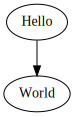

In [10]:
from graphviz import Digraph

g = Digraph('G')

g.edge('Hello', 'World')

g

### Задание 4: Визуализируйте следующий граф, используя библиотеку PyGraphviz:

In [ ]:
graph = { "a" : ["c"],
          "b" : ["c", "e"],
          "c" : ["a", "b", "d", "e"],
          "d" : ["c"],
          "e" : ["c", "b"],
          "f" : []
        } 

### Задание 5: Для того же графа, вам необходимо визуализировать его обход в ширину (bfs) и в глубину (dfs). Рекомендуется использовать изменение цвета вершин.